# Cosmological Analysis

###  Renée Hložek and Jeff McMahon

We are going to do a very rough example of an MCMC, using the <a href=" https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm"> Metroplis Hastings algorithm. </a>


We will start by pulling CAMB python so that we can get it running. Get pycamb from https://pypi.python.org/pypi/camb/0.1.1.

In [1]:
# Import CAMB
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
print('Using CAMB installed at '+ os.path.realpath(os.path.join(os.getcwd(),'..')))
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower

Using CAMB installed at C:\Users\jeffr\Documents\GitHub


In [2]:
# We will start by pulling initialising the CAMB params structure that we will use later. 
#This is similar to how you would change the params.ini file 

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
# The base cosmology model is set with these params, the others are all set to their default values
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
# The initial power spectrum is set here, separately from the rest of cosmology
pars.InitPower.set_params(ns=0.965, r=0)

# Set how far in multipole we want the power spectra, and turn on defaults for the params.
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calculate results for these parameters 
# this is like "running" camb from the command line, and is the same as how it is done in cosmomc
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)

In [3]:
# Let's see what the power spectra are:
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


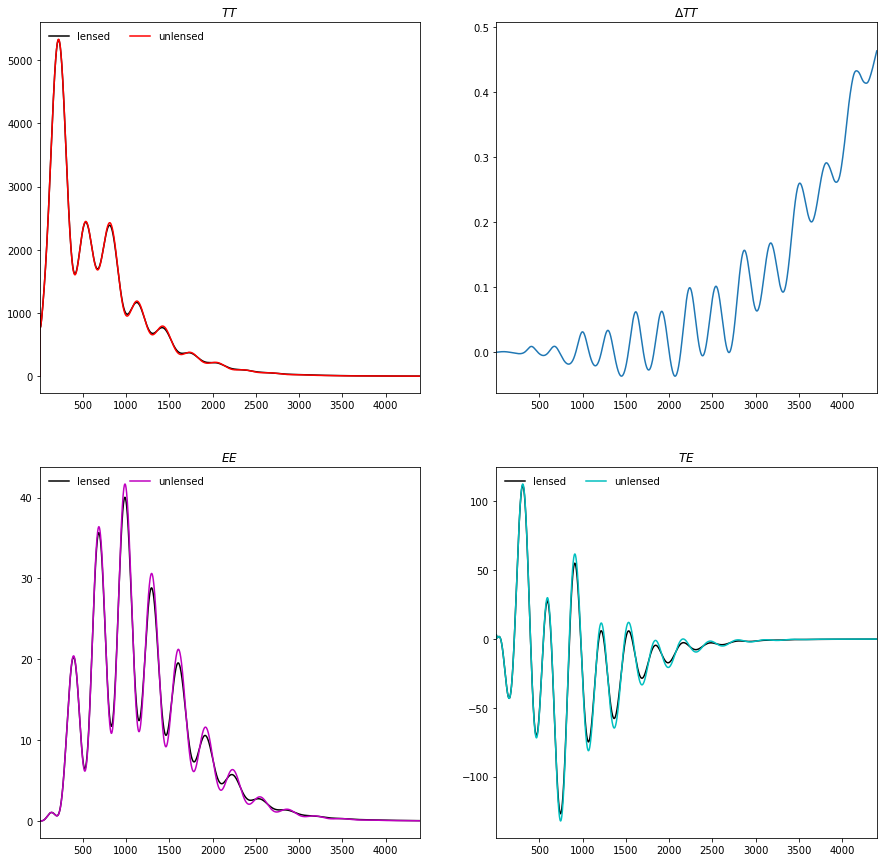

In [7]:
#Now we want to plot the total lensed and unlensed CMB power spectra
totCL=powers['total']
CMBOutscale = 7.43e12
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].plot(ls,CMBOutscale*totCL[:,0], color='k', label='lensed')
ax[0,0].plot(ls,CMBOutscale*unlensedCL[:,0], color='r', label='unlensed')
ax[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[0,1].plot(ls[2:], 1-unlensedCL[2:,0]/totCL[2:,0]);
ax[0,1].set_title(r'$\Delta TT$')

ax[0,0].set_title(r'$TT$')
ax[1,0].plot(ls,CMBOutscale*totCL[:,1], color='k', label='lensed')
ax[1,0].plot(ls,CMBOutscale*unlensedCL[:,1], color='m', label='unlensed')
ax[1,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2,frameon=False)
ax[1,0].set_title(r'$EE$')
ax[1,1].plot(ls,CMBOutscale*totCL[:,3], color='k', label='lensed')
ax[1,1].plot(ls,CMBOutscale*unlensedCL[:,3], color='c', label='unlensed')
ax[1,1].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[1,1].set_title(r'$TE$');

for ax in ax.reshape(-1): ax.set_xlim([2,4400])

### Now that we have run camb once and know how to do it, we can also compute the Cls over a range of parameters.

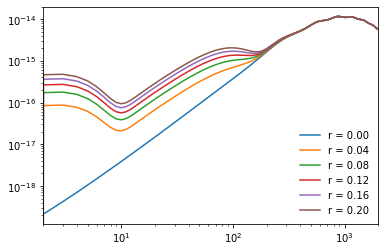

In [5]:
#You can calculate spectra for different primordial power spectra without recalculating everything
#for example, let's plot the BB spectra as a function of r
pars.WantTensors = True
results = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params)
    cl = results.get_total_cls(lmax)
    plt.loglog(np.arange(lmax+1),cl[:,2], label='r = %.2f'%r)
plt.xlim([2,lmax])
plt.legend( loc='lower right', frameon=False);

## Now let's make a fake likelihood for CMB S4 TT data. NOTE that this is super simplified, in general we have a much more complicated likelihood, and any other spectra will be correlated.

In [20]:
## Fake likelihood based on realistic high-ell noise for CMB S4 data 

def s4_tt_likelihood(modell,data=[],loaddata=False):
    if loaddata: 
        # if it is the first time, load the data
        data = np.loadtxt('./binned_errors.dat', unpack=True)
    modeltt = np.zeros(len(data[0]))
    inds = (data[0]-0.5)
    inds = inds.astype(int)
    for i,ind in enumerate(inds):
        modeltt[i] = modell[ind]
    #plt.figure()
    #plt.plot(data[0],modeltt)
    #plt.errorbar(data[0], data[1], data[2])
    
    loglike = (data[1]-modeltt)**2/(2.*data[2]**2)
    loglike=-np.sum(loglike,axis=0)
    return loglike, data
    

The first thing we notice is that we shouldn't just be taking the model spectrum at that bin, but we should be binning the theory.
<font color='red'>EXCERCISE: </font>  Write a module to bin the theory over the same ell range as the binned data.

In [21]:
# Your code here

Your discussion here.

In [22]:
# Let's call the module for the spectrum we have above.

model = totCL
cltt = totCL[:,0]*CMBOutscale
loglike, data = s4_tt_likelihood(cltt, loaddata=True)
print(loglike)


-5083.172147257008


### We are now going to call CAMB with a param vector in the same way as above, and compute the log likelihood for this.

In [23]:
paramsvec=np.array([67.5,0.022, 0.122, 0, 0.06, 0.965])
pars = camb.CAMBparams()
pars.set_cosmology(H0=paramsvec[0], ombh2=paramsvec[1], omch2=paramsvec[2], mnu=0.06, omk=paramsvec[3], tau=paramsvec[4])
pars.InitPower.set_params(ns=paramsvec[5], r=0)
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)
totCL=powers['total']
model = totCL
cltt = totCL[:,0]*CMBOutscale
loglike, data = s4_tt_likelihood(cltt, data=data)
print(loglike)

-5083.172147257008


### We want to take a step in this 6-D parameter space specified by the step vector. 

In [24]:
# Using this code above, we can take a gaussian step specified by the step vector below
stepvec = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])
nsteps = 2
loglike = np.zeros(nsteps)
for i in range(nsteps):
    if i==0:
        # First step
        step = paramsvec
    else:
        # Take a Gaussian step from the previous position
        step = step+np.random.randn(len(paramsvec))*stepvec
    # Initialise the CMAB params    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
    pars.InitPower.set_params(ns=step[5], r=0)
    pars.set_for_lmax(4400, lens_potential_accuracy=0)
    # Compute the spectra
    powers =results.get_cmb_power_spectra(pars)
    totCL=powers['total']
    model = totCL
    cltt = totCL[:,0]*CMBOutscale
    loglike[i], data = s4_tt_likelihood(cltt, data=data)
print('loglike vector =', loglike)

loglike vector = [-5083.17214726 -5418.54833768]


## MCMC
We are now ready to do the MCMC. We'll define the simplest/ugliest version of the Metropolis Hastings algorithm:

In [25]:
def mcmc_mh(ratln):
    accept=False
    r1 = np.random.rand()
    # If the step is definitely better, we want to accept it.
    # If it isn't necessarily better, we want to throw a random number and step if we exceed it
    if np.exp(ratln) > r1:
        accept=True
    return accept

In [ ]:
def camb_paramshift(trans_fns, step, lmax):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
    pars.InitPower.set_params(ns=step[5], r=0)
    pars.set_for_lmax(4400, lens_potential_accuracy=0)
    trans_fns.power_spectra_from_transfer(pars)
    cl = trans_fns.get_total_cls(lmax)
    return powers['total']

In [27]:
# Using this code above, we can take a gaussian step specified by the step vector below
stepvec = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])

steps = 100
loglike = np.zeros(steps)
stepskeep = np.zeros((steps,len(paramsvec)+1))
acceptkeep =  np.zeros(steps, dtype=np.bool)
for i in range(steps):
    if i==0:
        step = paramsvec
        accept=True
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        loglike[i], data = s4_tt_likelihood(cltt, data=data)
        #print loglike[i]
        stepskeep[i,0:len(paramsvec)] = step
        stepskeep[i,len(paramsvec)]= loglike[i]
    else:
        step = stepskeep[i-1,0:len(paramsvec)]+np.random.randn(len(paramsvec))*stepvec
        #print step
        pars = camb.CAMBparams()
        # Put the param vector into the camb structure
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        # compute the power spectrum
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        # compute the likelihood
        loglike[i], data = s4_tt_likelihood(cltt, data=data)
        rat = loglike[i]-loglike[i-1]
        accept = mcmc_mh(rat)
        
        if accept:   
            stepskeep[i,0:len(paramsvec)] = step
            stepskeep[i,len(paramsvec)] = loglike[i]
        else:
            stepskeep[i,0:len(paramsvec)] = stepskeep[i-1,0:len(paramsvec)]
            loglike[i] = loglike[i-1]
            stepskeep[i,len(paramsvec)] = loglike[i]
    if accept:
        acceptkeep[i] = True;
    
            
np.savetxt('chain.txt', stepskeep, delimiter=' ', fmt='%.3e')
acceptratio = np.size(acceptkeep[acceptkeep==True])/np.size(acceptkeep[acceptkeep==False])
print('we are done. %.3f', acceptratio)

<ipython-input-25-c8326ddbdd01>:6: RuntimeWarning: overflow encountered in exp
  if np.exp(ratln) > r1:


we are done


### We don't actually want to read in the data every time. 
<font color='red'>EXCERCISE: </font> Change the likelihood function to only read in the data the first time it is called.

In [17]:
## Your code here
# See changed fn above
    

Your notes here.

(7, 100)


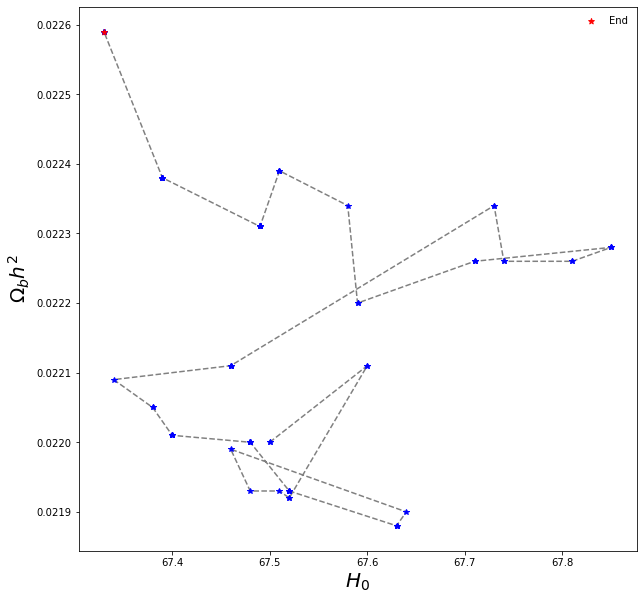

In [46]:
# Read in the chain
chain = np.loadtxt('chain.txt', unpack=True)
print(np.shape(chain))
plt.figure(figsize=(10,10))
plt.plot(chain[0,0:-2], chain[1,0:-2], marker='*', linestyle='--', c='gray', mfc='blue', mec='blue', zorder=0)
plt.scatter(chain[0,-1], chain[1,-1], marker='*', c='r', label='End', zorder=1)
plt.xlabel(r'$H_0$', fontsize=20)
plt.ylabel(r'$\Omega_bh^2$', fontsize=20)
plt.legend(frameon=False)
plt.show()

### This code is really ugly (and slow)!
<font color='red'>EXCERCISE: </font>  Write functions/modules to speed up the MCMC code above.

In [ ]:
## Your code here


Your discussion here.

### We now want to check the acceptance/rejection ratio of the chains. In general we want it to be between 0.2-0.4. To change this, you change the size of the steps in each parameter direction.

<font color='red'>EXCERCISE: </font>  Modify your code above to compute the acceptance/rejection ratio while the steps are being taken.

In [28]:
## Your code here
print(acceptratio)

0.3333333333333333


In [ ]:
Your discussion here.

### In general, it helps to be at a) a good part in parameter space when you start and b) to not step using a diagonal step matrix, but to step using the correlation between parameters.

<font color='red'>EXCERCISE: </font>  Modify your stepping function to take a covariance matrix (determined from a shorter run of the chain) and to step using this covariance matrix.

In [ ]:
## Your code here

Your discussion here.